### Question 2

#### A. Data Source:
[DMO website](https://www.dmo.gov.ng/fgn-bonds/fgn-bond-updates/1935-fgn-bonds-weekly-trading-highlights-report-as-at-february-06-to-february-10-2017/file)

The Government security picked is from NIGERIA, the country of two of the group member

##### About DMO:
DMO is the acronym od Debt Management Office, it was created in October 4, 2000 to coordinate the management of Nigeria's debt. ([Debt Management Office](https://www.dmo.gov.ng/about-dmo))

#### B. Defining the Maturity and Yield array according to the data source

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
maturities = [0.21, 0.46, 0.55, 1.30, 2.38, 2.70, 3.01, 4.42, 4.96, 7.09, 8.95, 11.80, 12.28, 12.78, 13.45, 17.43, 19.10]
yields = [14.05, 18.20, 19.12, 19.79, 16.13, 16.35, 16.56, 16.56, 16.23, 16.20, 16.76, 16.50, 16.46, 16.42, 16.36, 16.00, 16.84 ]
bond_dict = {"Maturity": maturities, "Yield (%)": yields}
bond = pd.DataFrame(bond_dict)
bond

,Maturity,Yield (%)
0,0.21,14.05
1,0.46,18.20
2,0.55,19.12
3,1.30,19.79
4,2.38,16.13
5,2.70,16.35
6,3.01,16.56
7,4.42,16.56
8,4.96,16.23
9,7.09,16.20


##### Plotting the yield curve for the data

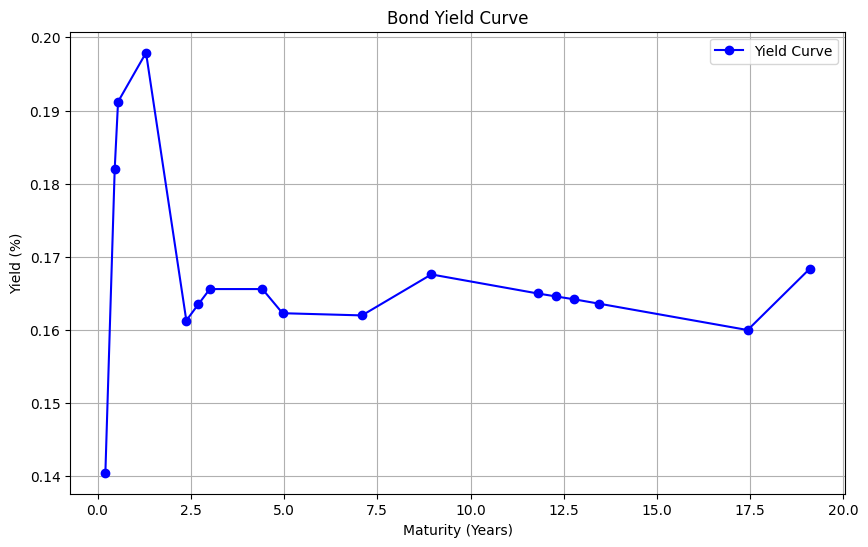

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(bond["Maturity"], bond["Yield (%)"]/100, marker='o', linestyle='-', color='b', label='Yield Curve')
plt.title("Bond Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()

#### C. Fitting Nelson Siegel model

##### Nelson-Siegel Yield Curve Formula

The Nelson-Siegel yield curve is given by:
$$
y(t) = \beta_0 + \beta_1 \cdot \frac{1 - e^{-\lambda t}}{\lambda t} + \beta_2 \cdot \left( \frac{1 - e^{-\lambda t}}{\lambda t} - e^{-\lambda t} \right)
$$

Where:
- $y(t)$: Yield for a given maturity
- $\beta_0$: Long-term level of interest rates
- $\beta_1$: Short-term component
- $\beta_2$: Medium-term component (hump shape)
- $\lambda$: Decay factor controlling the exponential rate of decline

Note: lambda in the formula is the same as tau in the code, I use lambda in the formula because of the ressemblance of tau and t as t is also present in the formula


NelsonSiegelCurve(beta0=np.float64(0.15955966972332303), beta1=np.float64(-0.15098613747320497), beta2=np.float64(0.2995051539138278), tau=np.float64(0.21970466519503065))
Beta0: 0.15955966972332303
Beta1: -0.15098613747320497
Beta2: 0.2995051539138278
Tau: 0.21970466519503065


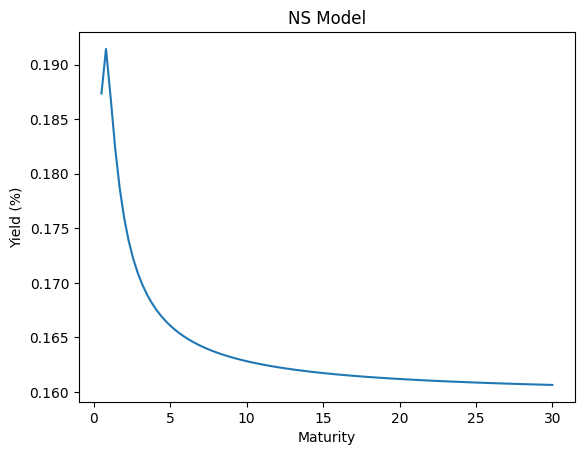

In [15]:
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
t = np.array(bond["Maturity"])
y = np.array(bond["Yield (%)"]/100)
curve, status = calibrate_ns_ols(t, y, tau0 = 1.0) 
assert status.success 
print(curve)

y_ns = curve
t_ns = np.linspace(0.5, 30, 100)
plt.plot(t_ns, y_ns(t_ns))
plt.xlabel("Maturity")
plt.ylabel("Yield (%)")
plt.title("NS Model")

# Extract parameters

beta0 = curve.beta0
beta1 = curve.beta1
beta2 = curve.beta2
tau = curve.tau

print(f"Beta0: {beta0}")
print(f"Beta1: {beta1}")
print(f"Beta2: {beta2}")
print(f"Tau: {tau}")


#### D. Cubic Spline Interpolation

In [16]:
#Selecting the Datapoints for the Interpolation
t_s = np.array([0.55, 3.01, 11.80, 19.10])
y_percent = np.array([19.12, 16.56, 16.50, 16.84])
y_s = y_percent/100
print(y_s)

[0.1912 0.1656 0.165  0.1684]


##### Creating the spline equations

$$
\begin{aligned}
f(x) &= a_1x^3 + b_1x^2 + c_1x + d_1 & \text{when } 0.55 \leq x \leq 3.01 \\
f(x) &= a_2x^3 + b_2x^2 + c_2x + d_2 & \text{when } 3.01 \leq x \leq 11.80 \\
f(x) &= a_3x^3 + b_3x^2 + c_3x + d_3 & \text{when } 11.80 \leq x \leq 19.10
\end{aligned}
$$

##### Each spline will go through two consecutive Datapoints

$$
\begin{aligned}
a_1(0.55)^3 + b_1(0.55)^2 + c_1(0.55) + d_1 = 0.1912 ................................................. (1)\\
a_1(3.01)^3 + b_1(3.01)^2 + c_1(3.01) + d_1 = 0.1656 ................................................ (2)\\
a_2(3.01)^3 + b_2(3.01)^2 + c_2(3.01) + d_2  = 0.1656 ................................................ (3)\\
a_2(11.80)^3 + b_2(11.80)^2 + c_2(11.80) + d_2 = 0.1650 ...............................................(4)\\
a_3(11.80)^3 + b_3(11.80)^2 + c_3(11.80) + d_3= 0.1650 ...............................................(5)\\
a_3(19.10)^3 + b_3(19.10)^2 + c_3(19.10) + d_3 = 0.1684 ...............................................(6)\\
\end{aligned}
$$

##### Obtaining the equation of the first derivative of two consecutive splines, being continuous at their interior point

$$
\begin{align}
3a_1(3.01)^2 + 2b_1(3.01) + c_1 - 3a_2(3.01)^2 - 2b_2(3.01) - c_1 = 0 ...........................(7)\\
3a_2(11.80)^2 + 2b_2(11.80) + c_2 - 3a_3(11.80)^2 - 2b_3(11.80) - c_3 = 0 .......................(8)
\end{align}
$$

##### Obtaining the equation of the second derivative of two consecutive splines continuous at their interior point

$$
\begin{align}
6a_1(3.01) + 2b_1 - 6a_2(3.01) - 2b_2 = 0 ....................................(9)\\
6a_2(11.80) + 2b_2 - 6a_3(11.80) - 2b_3 = 0...................................(10)
\end{align}
$$

##### Obtaining the equations of the boundary conditions

$$
\begin{align}
6a_1(0.55) + 2b_1 = 0 ...............................................(11)\\
6a_3(19.10) + 2b_3 = 0 ..............................................(12)
\end{align}
$$

##### Represnting the equations with matrix

$$
\begin{aligned}
A * c = y\\
c = A^{-1} * y\\
\end{aligned}
$$
<br>
<br>
$$
\begin{bmatrix}
a_1\\
b_1\\
c_1\\
d_1\\
a_2\\
b_2\\
d_2\\
a_3\\
b_3\\
c_3\\
d_3
\end{bmatrix}
= \begin{bmatrix}
0.1664 & 0.3025 & 0.55 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
27.2709 & 9.0601 & 3.01 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 27.2709 & 9.0601 & 3.01 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1643.032 & 139.24 & 11.80 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1643.032 & 139.24 & 11.80 & 1\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 6967.871 & 364.81 & 19.10 & 1\\
27.1803 & 6.02 & 1 & 0 & -27.1803 & -6.02 & -1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 417.72 & 23.6 & 1 & 0 & -417.72 & -23.6 & -1 & 0\\
18.06 & 2 & 0 & 0 & -18.06 & -2 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 70.8 & 2 & 0 & 0 & -70.8 & -2 & 0 & 0\\
3.33 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 114.6 & 2 & 0 & 0
\end{bmatrix}^{-1}\bullet\begin{bmatrix}
0.1912\\
0.1656\\
0.1656\\
0.1650\\
0.1650\\
0.1684\\
0\\
0\\
0\\
0\\
0\\
0
\end{bmatrix}
$$

In [17]:
A = np.array([[0.1664, 0.3025, 0.55, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [27.2709, 9.0601, 3.01, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 27.2709, 9.0601, 3.01, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1643.032, 139.24, 11.80, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1643.032, 139.24, 11.80, 1],
              [0, 0, 0, 0, 0, 0, 0, 0, 6967.871, 364.81, 19.10, 1],
              [27.1803, 6.02, 1, 0, -27.1803, -6.02, -1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 417.72, 23.6, 1, 0, -417.72, -23.6, -1, 0],
              [18.06, 2, 0, 0, -18.06, -2, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 70.8, 2, 0, 0, -70.8, -2, 0, 0],
              [3.33, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 114.6, 2, 0, 0]])
y = np.array([0.1912, 0.1656, 0.1656, 0.1650, 0.1650, 0.1684, 0, 0, 0, 0, 0, 0])
c = (np.dot(np.linalg.inv(A), y)).reshape(3, -1)
print(c)

[[ 2.06613038e-04 -3.44010709e-04 -1.14583069e-02  1.97571752e-01]
 [-7.15804569e-05  2.16807655e-03 -1.90196895e-02  2.05158339e-01]
 [ 1.67064667e-05 -9.57280543e-04  1.78595242e-02  6.01000980e-02]]


##### Writting the function that calculates:
$$x^0 + x^1 + x^2 + x^3$$

In [18]:
def spline_interpol(coeffs, variables):
    expansion = np.hstack([coeffs[i]*(variables**i)for i in range(0, len(coeffs))])
    return np.sum(expansion, axis = 1)

##### Simulating 100 values of x and applying the above function to get the respective values of y

In [19]:
x_values = np.linspace(0.55,19.10,500)
# for values of x that are less than 5
y_1 = spline_interpol(c[0][::-1], x_values[x_values < 3.01].reshape(-1, 1))
# for values of x that are greater than or equal to 5 to x < 10
y_2 = spline_interpol(c[1][::-1], x_values[(x_values >= 3.01) & (x_values < 11.80)].reshape(-1, 1))
# from 10 to 30
y_3 = spline_interpol(c[2][::-1], x_values[x_values >= 11.80].reshape(-1, 1))
y_values = np.concatenate([y_1, y_2, y_3])

##### Plotting the result

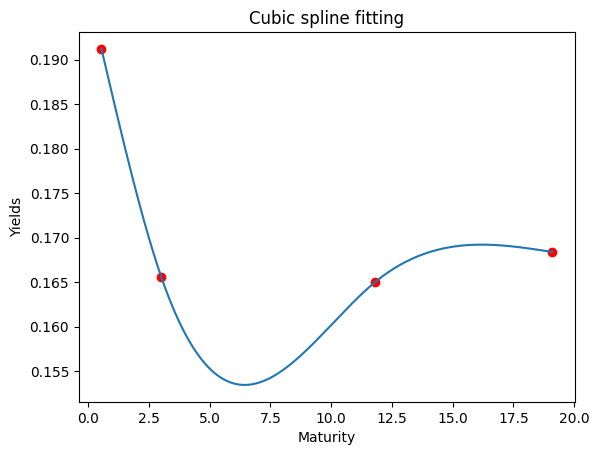

In [20]:
plt.plot(x_values, y_values)
plt.scatter(t_s, y_s, c = "red")
plt.xlabel("Maturity")
plt.ylabel("Yields")
plt.title("Cubic spline fitting")
plt.show()

#### E. Comparison of the models:

##### In terms of fit:

1. NS model is very smooth and is more ideal for capturing general trends. (Nelson & Siegel 473 - 489)
2. Cubic spline model offers high flexibility which gives it the advantage of fixing irregularies in data points and the disadvantage of overfitting ( McCulloch 811 - 830)

##### In terms of interpretation:
1. The parameters of NS fitting has economic meaning capturing long term, short term and medium term yield curve component (Nelson and Siegel 473 - 489)
2. The parameters of cubic spline model are purely mathematical and don't have direct economic interpretation(Adams and Van 1 - 15)

#### F. Parameters:

The parameters are outlined under the codes for each model

##### NS model Parameters:

In [21]:
beta0 = curve.beta0
beta1 = curve.beta1
beta2 = curve.beta2
tau = curve.tau

print(f"Beta0: {beta0}")
print(f"Beta1: {beta1}")
print(f"Beta2: {beta2}")
print(f"Tau: {tau}")

Beta0: 0.15955966972332303
Beta1: -0.15098613747320497
Beta2: 0.2995051539138278
Tau: 0.21970466519503065


##### Cubic Spline Parameters

In [22]:
print(c)

[[ 2.06613038e-04 -3.44010709e-04 -1.14583069e-02  1.97571752e-01]
 [-7.15804569e-05  2.16807655e-03 -1.90196895e-02  2.05158339e-01]
 [ 1.67064667e-05 -9.57280543e-04  1.78595242e-02  6.01000980e-02]]


The parameters of cubic spline are arranged in the pattern below:

the output of the matrix above is of the form:
$$c = \begin{bmatrix}
    a_1 & b_1 & c_1 & d_1 \\
    a_2 & b_2 & c_2 & d_2 \\
    a_3 & b_3 & c_3 & d_3 
\end{bmatrix}$$

#### References:
1. Debt Management Office, "FGN bonds update", 13 february, 2017, https://www.dmo.gov.ng/fgn-bonds/fgn-bond-updates/1935-fgn-bonds-weekly-trading-highlights-report-as-at-february-06-to-february-10-2017/file.
2. Nelson, Charles R., and Andrew F. Siegel. "Parsimonious Modeling of Yield Curves." *The Journal of Business*, vol. 60, no. 4, 1987, pp. 473-489.
3. McCulloch, John H. "The Tax-Adjusted Yield Curve." The Journal of Finance, vol. 30, no. 3, 1975, pp. 811-830.
4. Adams, J., and R. van Deventer. "Maximum Smoothness Forward Rates and Related Yields." Basic Building Blocks of Yield Curve Smoothing, SAS Risk Data and Analytics, 2012, pp. 1-15